# ETL (Extraccion, Transformacion y Carga)

### E xtracción
👉 Objetivo: Obtener los datos desde una fuente (en este caso, desde Google Drive).

In [1]:
from datetime import date
from google.colab import drive

import pyarrow.parquet as pq # Import pyarrow para leer archivos .parquet
import pandas as pd

# Montamos Google Drive para acceder al archivo
drive.mount('/content/drive', force_remount=True)

# Ruta archivo de entrada
ruta_archivo = '/content/drive/MyDrive/Colab_Notebooks/TP_Info/inputs/green_tripdata_2025-01.parquet'

try:
  table = pq.read_table(ruta_archivo) # pyarrow para leer
  df = table.to_pandas()

  print('Extraccion de datos exitosa')
except FileNotFoundError:
  print(f'No se puedo realizar la extraccion de {ruta_archivo}')
except Exception as e:
  print(f"An error occurred: {e}")

Mounted at /content/drive
Extraccion de datos exitosa


In [2]:
# Resumen de la informacion del DataFrame
print("\nInformación del DataFrame:")
df.info()


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48326 non-null  int32         
 1   lpep_pickup_datetime   48326 non-null  datetime64[us]
 2   lpep_dropoff_datetime  48326 non-null  datetime64[us]
 3   store_and_fwd_flag     46490 non-null  object        
 4   RatecodeID             46490 non-null  float64       
 5   PULocationID           48326 non-null  int32         
 6   DOLocationID           48326 non-null  int32         
 7   passenger_count        46490 non-null  float64       
 8   trip_distance          48326 non-null  float64       
 9   fare_amount            48326 non-null  float64       
 10  extra                  48326 non-null  float64       
 11  mta_tax                48326 non-null  float64       
 12  tip_amount             48326 non

In [3]:
# --- Filtro por rango de fechas en ETL (Opcional) ---

fecha_inicio_filtro_etl = None
fecha_fin_filtro_etl = None
# Ejemplo: pd.to_datetime('2025-01-20')
# Si no se especifica/n (son None), no aplicará el filtro por la fecha correspondiente.

# Nombre de la columna datetime a usar para el filtro (ej: 'lpep_pickup_datetime' o 'lpep_dropoff_datetime')
columna_fecha_filtro = 'lpep_pickup_datetime'

# Verifico si el DataFrame 'df': existe, no está vacío y la columna de fecha existe
if 'df' in locals() and not df.empty and columna_fecha_filtro in df.columns:

    # Aseguro que la columna seleccionada sea tipo datetime (ya lo son en este dataset, pero es buena práctica verificar)
    if pd.api.types.is_datetime64_any_dtype(df[columna_fecha_filtro]):
        print(f"Aplicando filtro de fecha en la columna '{columna_fecha_filtro}'")
        df_filtrado = df.copy() # Trabajo sobre una copia para el filtrado

        # Aplicar filtro de fecha de inicio si está especificado
        if fecha_inicio_filtro_etl is not None:
            print(f"  - Desde: {fecha_inicio_filtro_etl.date()}")
            df_filtrado = df_filtrado[df_filtrado[columna_fecha_filtro] >= fecha_inicio_filtro_etl].copy()
        # Aplicar filtro de fecha de fin si está especificado
        if fecha_fin_filtro_etl is not None:
            print(f"  - Hasta: {fecha_fin_filtro_etl.date()}")
            df_filtrado = df_filtrado[df_filtrado[columna_fecha_filtro] <= fecha_fin_filtro_etl].copy()

        # Actualizo el DataFrame principal con el resultado del filtrado
        df = df_filtrado

        if fecha_inicio_filtro_etl is not None or fecha_fin_filtro_etl is not None:
            print(f"Filtrado de datos en ETL aplicado. Número de filas restantes: {len(df)}")
        else:
            print("No se aplicó filtro de fecha en ETL. DataFrame completo.")
    else:
        print(f"⚠️ La columna '{columna_fecha_filtro}' no es de tipo datetime. No se aplicó el filtro de fecha en ETL.")
else:
    if 'df' not in locals() or df.empty:
        print("⚠️ El DataFrame 'df' no existe o está vacío. No se aplicó el filtro de fecha en ETL.")
    elif columna_fecha_filtro not in df.columns:
         print(f"⚠️ La columna '{columna_fecha_filtro}' no se encontró en el DataFrame. No se aplicó el filtro de fecha en ETL.")

Aplicando filtro de fecha en la columna 'lpep_pickup_datetime'
No se aplicó filtro de fecha en ETL. DataFrame completo.


### T ransformación
👉 Objetivo: Limpiar, normalizar, o modificar los datos antes de guardarlos o analizarlos.

In [4]:
# Muestra las primeras 5 filas del DataFrame
df.head()


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [5]:
# Cargar el archivo taxi_zone_lookup.csv para enriquecer datos

import chardet

# Ruta al archivo taxi_zone_lookup.csv en Google Drive
ruta_lookup_archivo = '/content/drive/MyDrive/Colab_Notebooks/TP_Info/inputs/taxi_zone_lookup.csv'

try:
    # Detecto la codificación del archivo CSV
    with open(ruta_lookup_archivo, 'rb') as f:
        result_lookup = chardet.detect(f.read())

    # Cargo el archivo CSV en un DataFrame
    df_zones = pd.read_csv(ruta_lookup_archivo, encoding=result_lookup['encoding'])

    print('Carga del archivo taxi_zone_lookup.csv exitosa')
    print("\nInformación del DataFrame de zonas:")
    df_zones.info()

    print("\nDatos de la cabecera del df_zones:")
    display(df_zones.head())

except FileNotFoundError:
    print(f'No se pudo encontrar el archivo de zonas: {ruta_lookup_archivo}')
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo de zonas: {e}")

Carga del archivo taxi_zone_lookup.csv exitosa

Información del DataFrame de zonas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       264 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB

Datos de la cabecera del df_zones:


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [6]:
# Combino el DataFrame principal (df) con el DataFrame de zonas (df_zones)

# PU significa Pick-Up (ascenso/abordaje del pasajero)
df_zones_pu = df_zones[['LocationID', 'Borough', 'Zone', 'service_zone']].rename(columns={'LocationID': 'PULocationID', 'Borough': 'PU_Borough', 'Zone': 'PU_Zone', 'service_zone': 'PU_Service_Zone'})
df_merged = pd.merge(df, df_zones_pu,
                     on='PULocationID',
                     how='left')
df_merged = df_merged.drop(columns=['PULocationID'])

# DO significa Drop-Off (bajada/descenso del pasajero)
df_zones_do = df_zones[['LocationID', 'Borough', 'Zone', 'service_zone']].rename(columns={'LocationID': 'DOLocationID', 'Borough': 'DO_Borough', 'Zone': 'DO_Zone', 'service_zone': 'DO_Service_Zone'})
df_merged = pd.merge(df_merged, df_zones_do,
                     on='DOLocationID',
                     how='left')
df_merged = df_merged.drop(columns=['DOLocationID'])

print("DataFrame combinado exitosamente con información de zonas.")

# Actualizo el DataFrame principal con el resultado del DataFrame combinado
df = df_merged

DataFrame combinado exitosamente con información de zonas.


In [7]:
# Resumen de la informacion del DataFrame (datos después de la combinacion)
print("\nInformación del DataFrame después de la combinacion:")
df.head()



Información del DataFrame después de la combinacion:


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,PU_Borough,PU_Zone,PU_Service_Zone,DO_Borough,DO_Zone,DO_Service_Zone
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,1.0,5.93,24.70,1.0,0.5,...,1.0,1.0,0.00,0.0,Manhattan,East Harlem South,Boro Zone,Bronx,University Heights/Morris Heights,Boro Zone
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,1.0,1.32,8.60,1.0,0.5,...,2.0,1.0,0.00,0.0,Manhattan,Morningside Heights,Boro Zone,Manhattan,East Harlem South,Boro Zone
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,1.0,0.41,25.55,0.0,0.0,...,2.0,2.0,0.00,0.0,Queens,Murray Hill-Queens,Boro Zone,Queens,East Flushing,Boro Zone
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,1.0,4.12,21.20,1.0,0.5,...,1.0,1.0,0.00,0.0,Manhattan,East Harlem North,Boro Zone,Queens,Steinway,Boro Zone
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,1.0,4.71,33.80,1.0,0.5,...,1.0,1.0,2.75,0.0,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Manhattan,Meatpacking/West Village West,Yellow Zone


In [8]:
# Decodificación de columnas codificadas usando .map()

# Crear diccionarios de búsqueda
vendor_map = {
    1: 'Creative Mobile Technologies, LLC',
    2: 'Curb Mobility, LLC',
    6: 'Myle Technologies Inc'
}

ratecode_map = {
    1: 'Tarifa estándar',
    2: 'Aeropuerto JFK',
    3: 'Aeropuerto Newark',
    4: 'Nassau o Westchester',
    5: 'Tarifa negociada',
    6: 'Viaje compartido (Group ride)',
    99: 'Nulo o desconocido'
}

payment_map = {
    0: 'Viaje Flex Fare',
    1: 'Tarjeta de crédito',
    2: 'Efectivo',
    3: 'Sin cargo',
    4: 'Disputa',
    5: 'Desconocido',
    6: 'Viaje anulado'
}

trip_map = {
    1: 'Tomado en la calle (Street-hail)',
    2: 'Solicitado por aplicación (Dispatch)'
}

# El .map() funcionará directamente si la columna es numérica, si hay nulos float lo maneja.
# Aplico .map() a las columnas originales para reemplazarlas con descripciones
# Mapeo VendorID
df['VendorID'] = df['VendorID'].map(vendor_map)
print("Columna 'VendorID' decodificada usando .map().")
# Mapeo RatecodeID
df['RatecodeID'] = df['RatecodeID'].map(ratecode_map)
print("Columna 'RatecodeID' decodificada usando .map().")
# Mapeo payment_type
df['payment_type'] = df['payment_type'].map(payment_map)
print("Columna 'payment_type' decodificada usando .map().")
# Mapeo trip_type
df['trip_type'] = df['trip_type'].map(trip_map)
print("Columna 'trip_type' decodificada usando .map().")


print("\nTodas las columnas codificadas principales han sido decodificadas en su lugar usando .map().")

Columna 'VendorID' decodificada usando .map().
Columna 'RatecodeID' decodificada usando .map().
Columna 'payment_type' decodificada usando .map().
Columna 'trip_type' decodificada usando .map().

Todas las columnas codificadas principales han sido decodificadas en su lugar usando .map().


In [9]:
columnas_traducidas = {
    'VendorID': 'ID_proveedor',                             # Empresa del taxi
    'lpep_pickup_datetime': 'Fecha_hora_ascenso',           # Inicio del viaje
    'lpep_dropoff_datetime': 'Fecha_hora_descenso',         # Fin del viaje
    'store_and_fwd_flag': 'Indicador_almacenamiento_envio', # Si el viaje se almacenó antes de enviarse
    'RatecodeID': 'Codigo_tarifa',                          # Tipo de tarifa (JFK, estándar, etc.)
    'passenger_count': 'Cantidad_pasajeros',                # Número de pasajeros
    'trip_distance': 'Distancia_viaje_millas',              # Longitud del viaje
    'fare_amount': 'Monto_tarifa_base',                     # Costo base del viaje
    'extra': 'Cargos_adicionales',                          # Suplementos (noche, clima, etc.)
    'mta_tax': 'Impuesto_MTA',                              # Impuesto fijo MTA
    'tip_amount': 'Monto_propina',                          # Propina (solo pagos con tarjeta)
    'tolls_amount': 'Monto_peajes',                         # Peajes durante el viaje
    'ehail_fee': 'Tarifa_electronica_eHail',                # Cargo por app (vacío normalmente)
    'improvement_surcharge': 'Recargo_mejora',              # Cargo fijo desde 2015
    'total_amount': 'Monto_total_viaje',                    # Suma de todos los costos
    'payment_type': 'Tipo_pago',                            # Efectivo, tarjeta, etc.
    'trip_type': 'Tipo_viaje',                              # Calle o app
    'congestion_surcharge': 'Recargo_congestion',           # Cargo por tráfico
    'cbd_congestion_fee': 'Cargo_congestion_CBD',           # Cargo en el distrito central
    'PU_Borough': 'Distrito_ascenso',                       # Borough (Manhattan, Bronx, etc.)
    'PU_Zone': 'Zona_ascenso',                              # Zona TLC de origen
    'PU_Service_Zone': 'Zona_servicio_ascenso',             # Categoría de zona (amarillo, verde, etc.)
    'DO_Borough': 'Distrito_descenso',                      # Borough de descenso
    'DO_Zone': 'Zona_descenso',                             # Zona TLC de descenso
    'DO_Service_Zone': 'Zona_servicio_descenso'             # Categoría de zona de descenso
}

# Renombrar las columnas del DataFrame
df.rename(columns=columnas_traducidas, inplace=True)

print("Columnas del DataFrame renombradas exitosamente.")

Columnas del DataFrame renombradas exitosamente.


In [10]:
# Defino el nuevo orden de las columnas para mejorar la lectura de datos para su posterior interpretacion
column_order = [
    'ID_proveedor',
    'Fecha_hora_ascenso',
    'Fecha_hora_descenso',
    'Distrito_ascenso',
    'Zona_ascenso',
    'Zona_servicio_ascenso',
    'Distrito_descenso',
    'Zona_descenso',
    'Zona_servicio_descenso',
    'Cantidad_pasajeros',
    'Distancia_viaje_millas',
    'Tipo_viaje',
    'Codigo_tarifa',
    'Monto_tarifa_base',
    'Cargos_adicionales',
    'Impuesto_MTA',
    'Monto_propina',
    'Monto_peajes',
    'Recargo_mejora',
    'Recargo_congestion',
    'Cargo_congestion_CBD',
    'Monto_total_viaje',
    'Tipo_pago',
    'Indicador_almacenamiento_envio',
    'Tarifa_electronica_eHail' # Mantengo la columna aunque tenga nulos, por ahora, se puede decidir eliminarla después
]

# Selecciono las columnas en el nuevo orden para preservar los datos
df = df[column_order].copy() # para evitar SettingWithCopyWarning

print("Columnas del DataFrame reubicadas exitosamente.\n")
df.info()
print("\nDatos de la cabecera del df:")
df.head()

Columnas del DataFrame reubicadas exitosamente.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID_proveedor                    48326 non-null  object        
 1   Fecha_hora_ascenso              48326 non-null  datetime64[us]
 2   Fecha_hora_descenso             48326 non-null  datetime64[us]
 3   Distrito_ascenso                48308 non-null  object        
 4   Zona_ascenso                    48221 non-null  object        
 5   Zona_servicio_ascenso           48203 non-null  object        
 6   Distrito_descenso               48199 non-null  object        
 7   Zona_descenso                   47854 non-null  object        
 8   Zona_servicio_descenso          47727 non-null  object        
 9   Cantidad_pasajeros              46490 non-null  float64       
 10  Distancia_viaje_milla

,ID_proveedor,Fecha_hora_ascenso,Fecha_hora_descenso,Distrito_ascenso,Zona_ascenso,Zona_servicio_ascenso,Distrito_descenso,Zona_descenso,Zona_servicio_descenso,Cantidad_pasajeros,...,Impuesto_MTA,Monto_propina,Monto_peajes,Recargo_mejora,Recargo_congestion,Cargo_congestion_CBD,Monto_total_viaje,Tipo_pago,Indicador_almacenamiento_envio,Tarifa_electronica_eHail
0,"Curb Mobility, LLC",2025-01-01 00:03:01,2025-01-01 00:17:12,Manhattan,East Harlem South,Boro Zone,Bronx,University Heights/Morris Heights,Boro Zone,1.0,...,0.5,6.80,0.00,1.0,0.00,0.0,34.00,Tarjeta de crédito,N,NaN
1,"Curb Mobility, LLC",2025-01-01 00:19:59,2025-01-01 00:25:52,Manhattan,Morningside Heights,Boro Zone,Manhattan,East Harlem South,Boro Zone,1.0,...,0.5,0.00,0.00,1.0,0.00,0.0,11.10,Efectivo,N,NaN
2,"Curb Mobility, LLC",2025-01-01 00:05:29,2025-01-01 00:07:21,Queens,Murray Hill-Queens,Boro Zone,Queens,East Flushing,Boro Zone,1.0,...,0.0,0.00,0.00,1.0,0.00,0.0,26.55,Efectivo,N,NaN
3,"Curb Mobility, LLC",2025-01-01 00:52:24,2025-01-01 01:07:52,Manhattan,East Harlem North,Boro Zone,Queens,Steinway,Boro Zone,1.0,...,0.5,6.13,6.94,1.0,0.00,0.0,36.77,Tarjeta de crédito,N,NaN
4,"Curb Mobility, LLC",2025-01-01 00:25:05,2025-01-01 01:01:10,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Manhattan,Meatpacking/West Village West,Yellow Zone,1.0,...,0.5,7.81,0.00,1.0,2.75,0.0,46.86,Tarjeta de crédito,N,NaN


In [11]:
# Cuento el número de valores nulos por columna
null_counts = df.isnull().sum()

# Calculo el porcentaje de valores nulos por columna
null_percentages = (null_counts / len(df)) * 100

# Creor un DataFrame con el conteo y porcentaje de nulos
null_info = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages
})

# Muestro solo las columnas con valores nulos, ordenadas por el conteo de nulos
null_info = null_info[null_info['Null Count'] > 0].sort_values(by='Null Count', ascending=False)

print("Información de valores nulos por columna:")
display(null_info)

Información de valores nulos por columna:


,Null Count,Null Percentage
Tarifa_electronica_eHail,48326,100.000000
Tipo_viaje,1843,3.813682
Cantidad_pasajeros,1836,3.799197
Codigo_tarifa,1836,3.799197
Cargo_congestion_CBD,1836,3.799197
Recargo_congestion,1836,3.799197
Tipo_pago,1836,3.799197
Indicador_almacenamiento_envio,1836,3.799197
Zona_servicio_descenso,599,1.239498
Zona_descenso,472,0.976700


In [12]:
# La ehail_fee (“E-Hail fee” o “electronic hail fee”) es una tarifa que se cobra por pedir un taxi o vehículo
# a través de una aplicación móvil en lugar de hacerlo en la calle o por teléfono.

# Contamos la frecuencia de cada tipo de viaje
trip_type_counts = df['Tipo_viaje'].value_counts(dropna=False)

print("Cantidad de viajes por 'Tipo de viaje':")
display(trip_type_counts)

# Se detecto que existen viajes solicitados mediante App pero los datos del campo eHail son 100% nulos.
# Entonces aunque el esquema de datos de los taxis de Nueva York incluye un campo para esta tarifa,
# es posible que para este conjunto de datos específico de enero de 2025, la columna no estuviera presente
# o estuviera completamente vacía desde el origen.
# Por ello procedemos a eliminar la columna al tener el 100% de sus datos nulos

# Elimino columna 'Tarifa_electronica_eHailTarifa_electronica_eHail'
df = df.drop(columns=['Tarifa_electronica_eHail'])

print("\n Columna 'Tarifa_electronica_eHail' eliminada exitosamente.")

Cantidad de viajes por 'Tipo de viaje':


,count
Tipo_viaje,
Tomado en la calle (Street-hail),44680
NaN,1843
Solicitado por aplicación (Dispatch),1803



 Columna 'Tarifa_electronica_eHail' eliminada exitosamente.


In [13]:
print('Resultado de la Transformacion:')
print("\nInformación del DataFrame:")
df.info()

print("\nDatos de la cabecera del df:")
df.head()

Resultado de la Transformacion:

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID_proveedor                    48326 non-null  object        
 1   Fecha_hora_ascenso              48326 non-null  datetime64[us]
 2   Fecha_hora_descenso             48326 non-null  datetime64[us]
 3   Distrito_ascenso                48308 non-null  object        
 4   Zona_ascenso                    48221 non-null  object        
 5   Zona_servicio_ascenso           48203 non-null  object        
 6   Distrito_descenso               48199 non-null  object        
 7   Zona_descenso                   47854 non-null  object        
 8   Zona_servicio_descenso          47727 non-null  object        
 9   Cantidad_pasajeros              46490 non-null  float64       
 10  Distancia_

,ID_proveedor,Fecha_hora_ascenso,Fecha_hora_descenso,Distrito_ascenso,Zona_ascenso,Zona_servicio_ascenso,Distrito_descenso,Zona_descenso,Zona_servicio_descenso,Cantidad_pasajeros,...,Cargos_adicionales,Impuesto_MTA,Monto_propina,Monto_peajes,Recargo_mejora,Recargo_congestion,Cargo_congestion_CBD,Monto_total_viaje,Tipo_pago,Indicador_almacenamiento_envio
0,"Curb Mobility, LLC",2025-01-01 00:03:01,2025-01-01 00:17:12,Manhattan,East Harlem South,Boro Zone,Bronx,University Heights/Morris Heights,Boro Zone,1.0,...,1.0,0.5,6.80,0.00,1.0,0.00,0.0,34.00,Tarjeta de crédito,N
1,"Curb Mobility, LLC",2025-01-01 00:19:59,2025-01-01 00:25:52,Manhattan,Morningside Heights,Boro Zone,Manhattan,East Harlem South,Boro Zone,1.0,...,1.0,0.5,0.00,0.00,1.0,0.00,0.0,11.10,Efectivo,N
2,"Curb Mobility, LLC",2025-01-01 00:05:29,2025-01-01 00:07:21,Queens,Murray Hill-Queens,Boro Zone,Queens,East Flushing,Boro Zone,1.0,...,0.0,0.0,0.00,0.00,1.0,0.00,0.0,26.55,Efectivo,N
3,"Curb Mobility, LLC",2025-01-01 00:52:24,2025-01-01 01:07:52,Manhattan,East Harlem North,Boro Zone,Queens,Steinway,Boro Zone,1.0,...,1.0,0.5,6.13,6.94,1.0,0.00,0.0,36.77,Tarjeta de crédito,N
4,"Curb Mobility, LLC",2025-01-01 00:25:05,2025-01-01 01:01:10,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Manhattan,Meatpacking/West Village West,Yellow Zone,1.0,...,1.0,0.5,7.81,0.00,1.0,2.75,0.0,46.86,Tarjeta de crédito,N


### L oad (Carga)
👉 Objetivo: Guardar los datos transformados en un nuevo archivo o base de datos.

In [14]:
try:
    if 'df' in locals():
        ruta_guardado = '/content/drive/MyDrive/Colab_Notebooks/TP_Info/df_transformado.csv'
        df.to_csv(ruta_guardado, index=False)
        print(f'✅ DataFrame transformado guardado exitosamente en: {ruta_guardado}')
    else:
        print('⚠️ No se encontró el DataFrame "df" para guardar.')
except Exception as e:
    print(f'❌ Error al guardar el DataFrame transformado: {e}')


✅ DataFrame transformado guardado exitosamente en: /content/drive/MyDrive/Colab_Notebooks/TP_Info/df_transformado.csv


# EDA

In [15]:
# Cargo df con los datos resultantes del ETL

import chardet

# Ruta al archivo df_transformados.csv en Google Drive
ruta_archivo_post_etl = '/content/drive/MyDrive/Colab_Notebooks/TP_Info/df_transformado.csv'

try:
    # Detecto la codificación del archivo CSV
    with open(ruta_archivo_post_etl, 'rb') as f:
        result_lookup = chardet.detect(f.read())

    # Cargo el archivo CSV en un DataFrame
    df = pd.read_csv(ruta_archivo_post_etl, encoding=result_lookup['encoding'])

    print('Carga del archivo df_transformados.csv exitosa')

except FileNotFoundError:
    print(f'No se pudo encontrar el archivo post ETL: {ruta_archivo_post_etl}')
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo post ETL: {e}")

Carga del archivo df_transformados.csv exitosa


In [16]:
    print("\nInformación del DataFrame para realizar EDA:")
    df.info()

    print("\nDatos de la cabecera del df:")
    df.head()


Información del DataFrame para realizar EDA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_proveedor                    48326 non-null  object 
 1   Fecha_hora_ascenso              48326 non-null  object 
 2   Fecha_hora_descenso             48326 non-null  object 
 3   Distrito_ascenso                48308 non-null  object 
 4   Zona_ascenso                    48221 non-null  object 
 5   Zona_servicio_ascenso           48203 non-null  object 
 6   Distrito_descenso               48199 non-null  object 
 7   Zona_descenso                   47854 non-null  object 
 8   Zona_servicio_descenso          47727 non-null  object 
 9   Cantidad_pasajeros              46490 non-null  float64
 10  Distancia_viaje_millas          48326 non-null  float64
 11  Tipo_viaje                      46483 non-null 

,ID_proveedor,Fecha_hora_ascenso,Fecha_hora_descenso,Distrito_ascenso,Zona_ascenso,Zona_servicio_ascenso,Distrito_descenso,Zona_descenso,Zona_servicio_descenso,Cantidad_pasajeros,...,Cargos_adicionales,Impuesto_MTA,Monto_propina,Monto_peajes,Recargo_mejora,Recargo_congestion,Cargo_congestion_CBD,Monto_total_viaje,Tipo_pago,Indicador_almacenamiento_envio
0,"Curb Mobility, LLC",2025-01-01 00:03:01,2025-01-01 00:17:12,Manhattan,East Harlem South,Boro Zone,Bronx,University Heights/Morris Heights,Boro Zone,1.0,...,1.0,0.5,6.80,0.00,1.0,0.00,0.0,34.00,Tarjeta de crédito,N
1,"Curb Mobility, LLC",2025-01-01 00:19:59,2025-01-01 00:25:52,Manhattan,Morningside Heights,Boro Zone,Manhattan,East Harlem South,Boro Zone,1.0,...,1.0,0.5,0.00,0.00,1.0,0.00,0.0,11.10,Efectivo,N
2,"Curb Mobility, LLC",2025-01-01 00:05:29,2025-01-01 00:07:21,Queens,Murray Hill-Queens,Boro Zone,Queens,East Flushing,Boro Zone,1.0,...,0.0,0.0,0.00,0.00,1.0,0.00,0.0,26.55,Efectivo,N
3,"Curb Mobility, LLC",2025-01-01 00:52:24,2025-01-01 01:07:52,Manhattan,East Harlem North,Boro Zone,Queens,Steinway,Boro Zone,1.0,...,1.0,0.5,6.13,6.94,1.0,0.00,0.0,36.77,Tarjeta de crédito,N
4,"Curb Mobility, LLC",2025-01-01 00:25:05,2025-01-01 01:01:10,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Manhattan,Meatpacking/West Village West,Yellow Zone,1.0,...,1.0,0.5,7.81,0.00,1.0,2.75,0.0,46.86,Tarjeta de crédito,N


In [17]:
# Limito los decimales de los floats
pd.options.display.float_format = '{:.2f}'.format

# Genero estadisticas descriptivas de las columnas numericas
df.describe()

,Cantidad_pasajeros,Distancia_viaje_millas,Monto_tarifa_base,Cargos_adicionales,Impuesto_MTA,Monto_propina,Monto_peajes,Recargo_mejora,Recargo_congestion,Cargo_congestion_CBD,Monto_total_viaje
count,46490.00,48326.00,48326.00,48326.00,48326.00,48326.00,48326.00,48326.00,46490.00,46490.00,48326.00
mean,1.28,21.53,16.76,0.93,0.60,2.48,0.18,0.99,0.85,0.05,22.63
std,0.94,990.65,13.31,1.35,0.36,3.21,1.19,0.13,1.27,0.19,15.44
min,0.00,0.00,-113.00,-5.00,-0.50,-0.90,0.00,-1.00,-2.75,0.00,-114.00
25%,1.00,1.10,9.30,0.00,0.50,0.00,0.00,1.00,0.00,0.00,13.71
50%,1.00,1.74,13.50,0.00,0.50,2.07,0.00,1.00,0.00,0.00,18.75
75%,1.00,2.94,19.10,2.50,0.50,3.69,0.00,1.00,2.75,0.00,26.46
max,9.00,84731.57,336.20,7.50,4.25,252.05,48.76,1.00,2.75,0.75,371.40


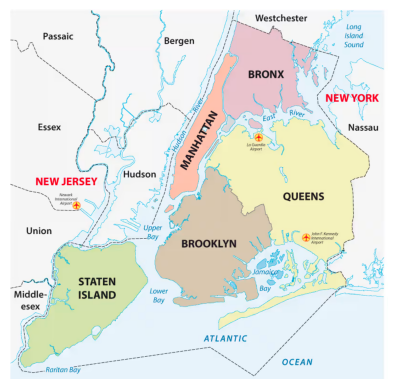

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta a la imagen del mapa politico
img = mpimg.imread('/content/drive/MyDrive/Colab_Notebooks/TP_Info/inputs/distritos_de_NYC_y_alrededores.png')

# Muestro la imagen
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

## 1. ¿Cuáles son los distritos y zonas con mayor actividad (frecuencia) de viajes de taxi verde según origen y descenso?
Este seria mas bien un análisis geográfico. Destinado a encontrar patrones relacionados con la ubicación de origen y destino de los viajes.

### por Distrito (borought)

In [25]:
# Cuento la frecuencia de cada distrito de ascenso
pu_borough_counts = df['Distrito_ascenso'].value_counts(dropna=False)
print("Cantidad de viajes por 'Distrito de ascenso':")
display(pu_borough_counts)
# Calculo y muestro el porcentaje de 'Unknown' y NaN para Distrito_ascenso
pu_unknown_nan_percentage = (pu_borough_counts.get('Unknown', 0) + pu_borough_counts.get(None, 0)) / len(df) * 100
print(f"\nPorcentaje de valores 'Unknown' y NaN en 'Distrito de ascenso': {pu_unknown_nan_percentage:.2f}%\n")

# Cuento la frecuencia de cada distrito de descenso
do_borough_counts = df['Distrito_descenso'].value_counts(dropna=False)
print("\nCantidad de viajes por 'Distrito de descenso':")
display(do_borough_counts)
# Calculo y muestro el porcentaje de 'Unknown' y NaN para Distrito_descenso
do_unknown_nan_percentage = (do_borough_counts.get('Unknown', 0) + do_borough_counts.get(None, 0)) / len(df) * 100
print(f"\nPorcentaje de valores 'Unknown' y NaN en 'Distrito de descenso': {do_unknown_nan_percentage:.2f}%\n")

# Conclusión del análisis
print("\nConclusión del análisis de Frecuencia por Distrito:")
print("- Manhattan es, por mucho, el distrito con la mayor cantidad de viajes de ascenso y descenso para los taxis verdes en enero de 2025.")
print("- Queens y Brooklyn también tienen una actividad significativa, mientras que el Bronx y Staten Island tienen mucha menor actividad.")
print("- Los valores 'Unknown' y NaN indican ubicaciones que no pudieron ser mapeadas a un distrito conocido.")

Cantidad de viajes por 'Distrito de ascenso':


,count
Distrito_ascenso,
Manhattan,30077
Queens,10740
Brooklyn,6813
Bronx,570
Unknown,105
NaN,18
Staten Island,3



Porcentaje de valores 'Unknown' y NaN en 'Distrito de ascenso': 0.22%


Cantidad de viajes por 'Distrito de descenso':


,count
Distrito_descenso,
Manhattan,30172
Queens,10520
Brooklyn,5893
Bronx,1114
Unknown,472
NaN,127
EWR,24
Staten Island,4



Porcentaje de valores 'Unknown' y NaN en 'Distrito de descenso': 0.98%


Conclusión del análisis de Frecuencia por Distrito:
- Manhattan es, por mucho, el distrito con la mayor cantidad de viajes de ascenso y descenso para los taxis verdes en enero de 2025.
- Queens y Brooklyn también tienen una actividad significativa, mientras que el Bronx y Staten Island tienen mucha menor actividad.
- Los valores 'Unknown' y NaN indican ubicaciones que no pudieron ser mapeadas a un distrito conocido.


### por Zona

In [26]:
# Frecuencia de cada zona de ascenso
pu_zone_counts = df['Zona_ascenso'].value_counts(dropna=False)
print("Las 10 zonas de ascenso más frecuentes son:")
display(pu_zone_counts.head(10))
# Cantidades de 'Unknown' y NaN para Zona_ascenso
asc_unknown_count = (df['Zona_ascenso'] == 'Unknown').sum()
asc_nan_count = df['Zona_ascenso'].isna().sum()
# Calcular el porcentaje para Zona_ascenso
#asc_unknown_percentage = asc_unknown_count / len(df) * 100
#print(f"\nPorcentaje de valores 'Unknown' en 'Zona de ascenso': {asc_unknown_percentage:.2f}%")
#asc_nan_percentage = asc_nan_count / len(df) * 100
#print(f"\nPorcentaje de valores NaN en 'Zona de ascenso': {asc_nan_percentage:.2f}%\n")
asc_unknown_nan_percentage = (asc_unknown_count + asc_nan_count) / len(df) * 100
print(f"\nPorcentaje de valores 'Unknown' y NaN en 'Zona de ascenso': {asc_unknown_nan_percentage:.2f}%\n")

# Contar la frecuencia de cada zona de descenso
do_zone_counts = df['Zona_descenso'].value_counts(dropna=False)
print("\nLas 10 zonas de descenso más frecuentes son:")
display(do_zone_counts.head(10))
# Calculo 'Unknown' y NaN para Zona_descenso
do_unknown_count = (df['Zona_descenso'] == 'Unknown').sum()
do_nan_count = df['Zona_descenso'].isna().sum()
# Calcular el porcentaje para Zona_descenso
#do_unknown_percentage = do_unknown_count / len(df) * 100
#print(f"\nPorcentaje de valores 'Unknown' en 'Zona de descenso': {do_unknown_percentage:.2f}%")
#do_nan_percentage = do_nan_count / len(df) * 100
#print(f"\nPorcentaje de valores NaN en 'Zona de descenso': {do_nan_percentage:.2f}%\n")
do_unknown_nan_percentage = (do_unknown_count + do_nan_count) / len(df) * 100
print(f"\nPorcentaje de valores 'Unknown' y NaN en 'Zona de descenso': {do_unknown_nan_percentage:.2f}%\n")

# Conclusión del análisis
print("\nConclusión del análisis de Frecuencia por Zona:")
print("- Las zonas más frecuentes para ascensos y descensos se concentran principalmente en Manhattan y Queens, con East Harlem North y East Harlem South destacándose en ambas.")
print("- Existe una cantidad significativa de viajes dentro de la misma zona, lo que sugiere viajes cortos o locales.")
print("- Las zonas con valores 'Unknown' o NaN representan ubicaciones que no pudieron ser mapeadas a una zona específica en el archivo de lookup.")

Las 10 zonas de ascenso más frecuentes son:


,count
Zona_ascenso,
East Harlem North,11682
East Harlem South,8065
Central Park,2776
Forest Hills,2242
Morningside Heights,2126
Fort Greene,2004
Central Harlem,1974
Elmhurst,1804
Downtown Brooklyn/MetroTech,1518



Porcentaje de valores 'Unknown' y NaN en 'Zona de ascenso': 0.22%


Las 10 zonas de descenso más frecuentes son:


,count
Zona_descenso,
East Harlem South,3187
Upper East Side North,2774
East Harlem North,2578
Upper West Side North,2013
Central Harlem,1617
Morningside Heights,1567
Yorkville West,1407
Central Harlem North,1375
Upper West Side South,1171



Porcentaje de valores 'Unknown' y NaN en 'Zona de descenso': 0.98%


Conclusión del análisis de Frecuencia por Zona:
- Las zonas más frecuentes para ascensos y descensos se concentran principalmente en Manhattan y Queens, con East Harlem North y East Harlem South destacándose en ambas.
- Existe una cantidad significativa de viajes dentro de la misma zona, lo que sugiere viajes cortos o locales.
- Las zonas con valores 'Unknown' o NaN representan ubicaciones que no pudieron ser mapeadas a una zona específica en el archivo de lookup.


## 2. ¿Cómo se relacionan la distancia del viaje, el monto total y la propina?
Para este parte del analisis nos valemos de graficos de dispercion que reflejan de manera visual su respectiva correlacion y de la matriz de correlaciones para obtener informacion.

### Distancia, monto total y propina (dispersión)

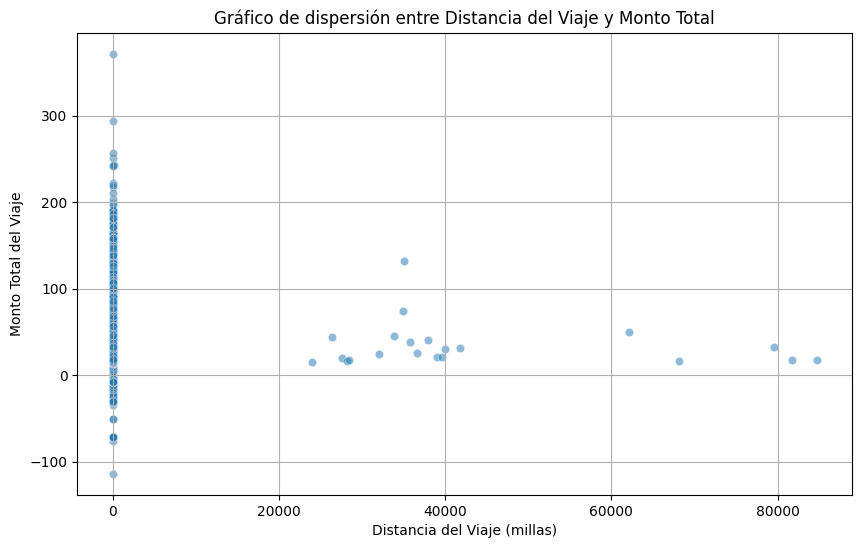

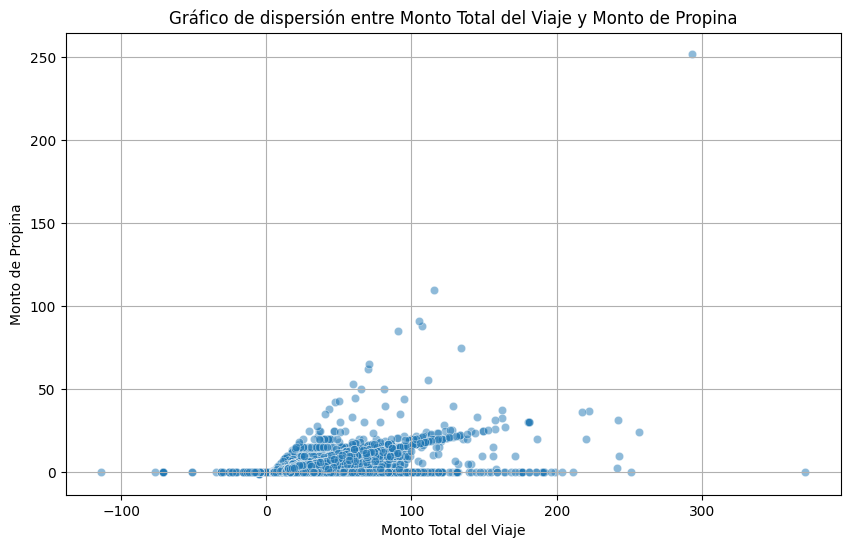




Matriz de correlación:


,Distancia_viaje_millas,Monto_total_viaje,Monto_propina
Distancia_viaje_millas,1.00,0.02,0.00
Monto_total_viaje,0.02,1.00,0.51
Monto_propina,0.00,0.51,1.00



Conclusión del análisis de la Relación entre Distancia, Monto Total y Propina:
- Existe una correlación moderada y positiva entre el monto total del viaje y la propina (correlación de 0.513).
- La correlación entre la distancia del viaje y el monto total/propina es muy baja, posiblemente debido a valores atípicos significativos en la distancia.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

#Como interpretar el patrón en grafico de dispersion:
#Correlación positiva: Si los puntos tienden a subir de izquierda a derecha, significa que a mayor distancia, mayor es el monto total.
#Correlación negativa: Si los puntos tienden a bajar de izquierda a derecha, indica que a mayor distancia, menor es el monto total.
#Sin correlación: Si los puntos están dispersos sin un patrón claro, no hay una relación lineal evidente entre las dos variables.
#Fuerza de la relación: La cercanía de los puntos a una línea de tendencia puede indicar la fuerza de la correlación. Si los puntos están muy juntos, la relación es fuerte.

# Creo un scatter plot usando seaborn, para visualizar la relación entre Distancia_viaje_millas y Monto_total_viaje
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Distancia_viaje_millas', y='Monto_total_viaje', alpha=0.5) # alpha de 0.5 para hacer los puntos semi-transparentes
plt.title('Gráfico de dispersión entre Distancia del Viaje y Monto Total')
plt.xlabel('Distancia del Viaje (millas)')
plt.ylabel('Monto Total del Viaje')
plt.grid(True)
plt.show()
print("\n")

# Creo un scatter plot para visualizar la relación entre Monto_total_viaje y Monto_propina
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Monto_total_viaje', y='Monto_propina', alpha=0.5)
plt.title('Gráfico de dispersión entre Monto Total del Viaje y Monto de Propina')
plt.xlabel('Monto Total del Viaje')
plt.ylabel('Monto de Propina')
plt.grid(True)
plt.show()
print("\n")

# Calculo la correlación entre estas columnas
correlation_matrix = df[['Distancia_viaje_millas', 'Monto_total_viaje', 'Monto_propina']].corr()
print("\nMatriz de correlación:")
display(correlation_matrix)

# Conclusión del análisis
print("\nConclusión del análisis de la Relación entre Distancia, Monto Total y Propina:")
print("- Existe una correlación moderada y positiva entre el monto total del viaje y la propina (correlación de 0.513).")
print("- La correlación entre la distancia del viaje y el monto total/propina es muy baja, posiblemente debido a valores atípicos significativos en la distancia.")

### Manejo de valores atípicos(o distorsionados)

Número de filas originales: 48326
Número de filas después de filtrar valores atípicos: 45540




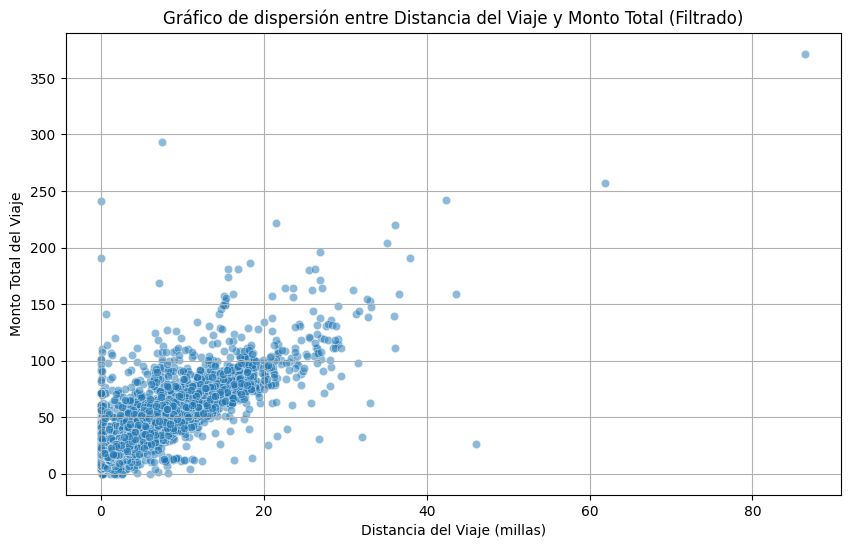

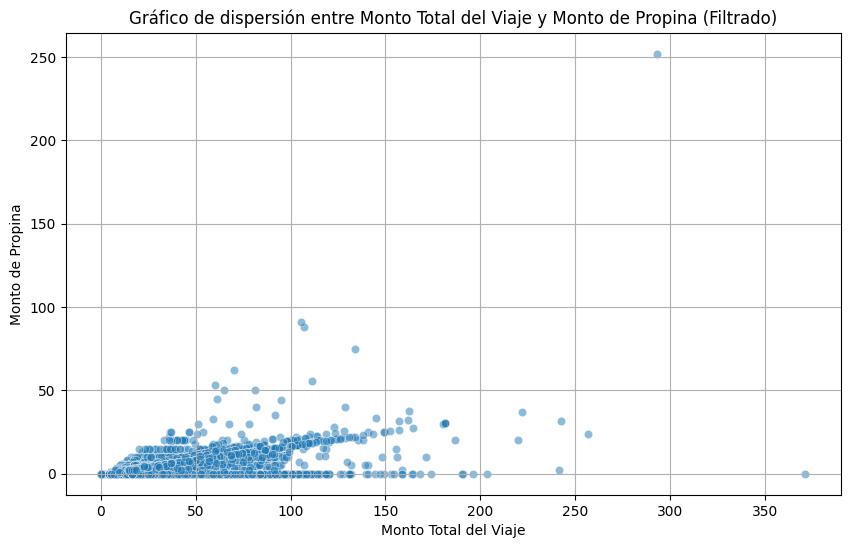




Matriz de correlación después de filtrar valores atípicos:


,Distancia_viaje_millas,Monto_total_viaje,Monto_propina
Distancia_viaje_millas,1.00,0.88,0.34
Monto_total_viaje,0.88,1.00,0.56
Monto_propina,0.34,0.56,1.00



Conclusiones del análisis en función a la matriz de correlación filtrada:
- Distancia del Viaje y Monto Total del Viaje (Correlación: 0.88): Existe una fuerte relación positiva. A mayor distancia del viaje, generalmente mayor es el costo total.
- Monto Total del Viaje y Monto de Propina (Correlación: 0.56): Existe una moderada relación positiva. Montos totales más altos tienden a estar asociados con propinas más grandes.
- Distancia del Viaje y Monto de Propina (Correlación: 0.34): Existe una débil relación positiva. La distancia del viaje tiene una influencia limitada y no directa en la cantidad de propina dejada.


In [22]:
# Defino umbrales para filtrar valores atípicos
# Basado en la inspección de lo anterior,
# un viaje de taxi verde que dure cientos o miles de millas es irreal.
# De manera similar, montos totales negativos o extremadamente altos también son sospechosos.
distancia_maxima = 100 # millas
monto_total_minimo = 0 # No debería haber montos negativos / eventualemente podria detectarse si fueron devoluciones o fallo en el sistema de registro
monto_total_maximo = 500 # Un umbral razonable para viajes de taxi verde

# Creo un nuevo DataFrame filtrando los valores atípicos
df_filtered = df[
    (df['Distancia_viaje_millas'] > 0) & (df['Distancia_viaje_millas'] <= distancia_maxima) &
    (df['Monto_total_viaje'] >= monto_total_minimo) & (df['Monto_total_viaje'] <= monto_total_maximo)].copy()

print(f"Número de filas originales: {len(df)}")
print(f"Número de filas después de filtrar valores atípicos: {len(df_filtered)}")
print("\n")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Distancia_viaje_millas', y='Monto_total_viaje', alpha=0.5)
plt.title('Gráfico de dispersión entre Distancia del Viaje y Monto Total (Filtrado)')
plt.xlabel('Distancia del Viaje (millas)')
plt.ylabel('Monto Total del Viaje')
plt.grid(True)
plt.show()
print("\n")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Monto_total_viaje', y='Monto_propina', alpha=0.5)
plt.title('Gráfico de dispersión entre Monto Total del Viaje y Monto de Propina (Filtrado)')
plt.xlabel('Monto Total del Viaje')
plt.ylabel('Monto de Propina')
plt.grid(True)
plt.show()
print("\n")

# Calculo la matriz de correlación con el DataFrame filtrado
correlation_matrix_filtered = df_filtered[['Distancia_viaje_millas', 'Monto_total_viaje', 'Monto_propina']].corr()

print("\nMatriz de correlación después de filtrar valores atípicos:")
display(correlation_matrix_filtered)

# Conclusiones en función a la matriz de correlación filtrada
print("\nConclusiones del análisis en función a la matriz de correlación filtrada:")
print("- Distancia del Viaje y Monto Total del Viaje (Correlación: 0.88): Existe una fuerte relación positiva. A mayor distancia del viaje, generalmente mayor es el costo total.")
print("- Monto Total del Viaje y Monto de Propina (Correlación: 0.56): Existe una moderada relación positiva. Montos totales más altos tienden a estar asociados con propinas más grandes.")
print("- Distancia del Viaje y Monto de Propina (Correlación: 0.34): Existe una débil relación positiva. La distancia del viaje tiene una influencia limitada y no directa en la cantidad de propina dejada.")

## 3. ¿Cómo varía la cantidad de viajes de taxi verde a lo largo de la semana y segun su origen/destino?

### Análisis de Tendencias Temporales (Viajes por Día de la Semana)

Cantidad de viajes por día de la semana:


,count
Dia_de_la_semana,
Lunes,5953
Martes,6993
Miércoles,8133
Jueves,9051
Viernes,8405
Sábado,5097
Domingo,4694


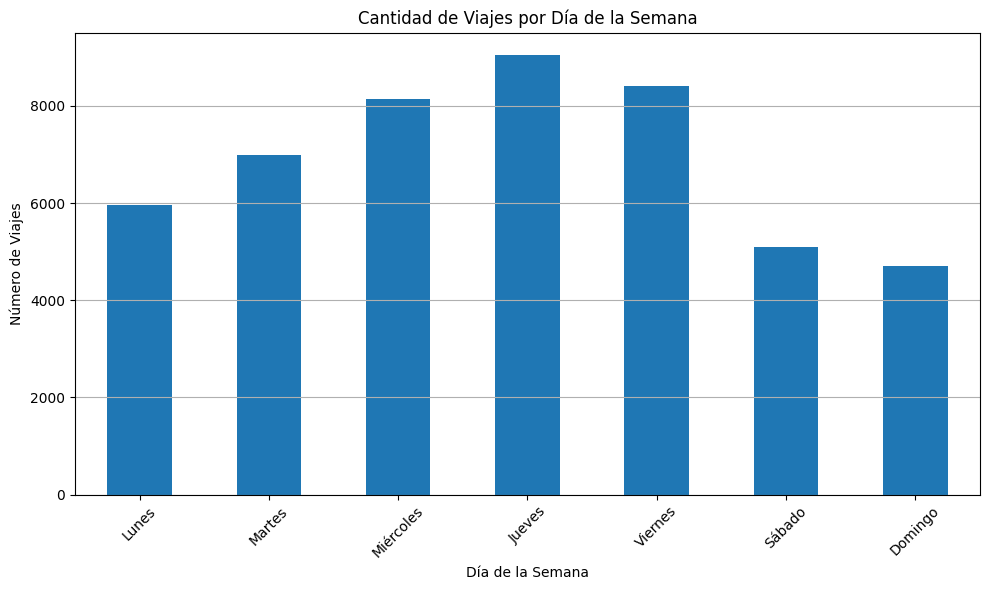


Conclusión del análisis de Tendencias Temporales (Viajes por Día de la Semana):
- Los jueves y viernes son los días con mayor cantidad de viajes.
- Los fines de semana (sábado y domingo) tienen la menor demanda de taxis verdes.


In [27]:
# Asegurarse de que la columna de fecha sea de tipo datetime
df['Fecha_hora_ascenso'] = pd.to_datetime(df['Fecha_hora_ascenso'])

# Extraer el día de la semana
df['Dia_semana_ascenso'] = df['Fecha_hora_ascenso'].dt.day_name()

# Mapear los nombres de los días a español
spanish_day_names = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df['Dia_de_la_semana'] = df['Dia_semana_ascenso'].map(spanish_day_names)

# Contar la frecuencia de viajes por día de la semana
trips_by_day = df['Dia_de_la_semana'].value_counts()

# Definir el orden de los días de la semana para la visualización en español
days_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
trips_by_day = trips_by_day.reindex(days_order)

print("Cantidad de viajes por día de la semana:")
display(trips_by_day)
print("\n")

# Visualizar los viajes por día de la semana en español
plt.figure(figsize=(10, 6))
trips_by_day.plot(kind='bar')
plt.title('Cantidad de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Conclusión del análisis
print("\nConclusión del análisis de Tendencias Temporales (Viajes por Día de la Semana):")
print("- Los jueves y viernes son los días con mayor cantidad de viajes.")
print("- Los fines de semana (sábado y domingo) tienen la menor demanda de taxis verdes.")

### Combinaciones de Origen-Destino

In [24]:
# Combinar las columnas de zona de ascenso y descenso para crear una columna de ruta
df['Ruta'] = df['Zona_ascenso'] + ' a ' + df['Zona_descenso']

# Contar la frecuencia de cada ruta
ruta_counts = df['Ruta'].value_counts()

print("Las 10 rutas (origen-destino) más frecuentes son:")
display(ruta_counts.head(10))

# Conclusiones:
print("\nConclusiones sobre las rutas más frecuentes:")
print("- Los viajes se concentran en zonas como East Harlem North y South.")
print("- Existe un flujo frecuente de viajes entre East Harlem y zonas cercanas en Manhattan y Queens.")

Las 10 rutas (origen-destino) más frecuentes son:


,count
Ruta,
East Harlem North a East Harlem South,2177
East Harlem South a East Harlem North,1439
East Harlem North a Upper East Side North,1309
East Harlem North a Morningside Heights,789
Forest Hills a Forest Hills,766
East Harlem South a Upper East Side North,734
East Harlem North a Central Harlem,673
East Harlem North a Yorkville West,648
East Harlem North a Upper West Side North,637



Conclusiones sobre las rutas más frecuentes:
- Los viajes se concentran en zonas como East Harlem North y South.
- Existe un flujo frecuente de viajes entre East Harlem y zonas cercanas en Manhattan y Queens.
